In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import os
import tqdm
import skimage.io
import glob

from tqdm import tqdm

In [2]:

from skimage.io import imread, imshow
from skimage.transform import resize

from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Instantiating the model for loading the weights and biases and preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

%matplotlib inline

In [3]:
# Reading Data

train_dataset_0_all = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

#test_dataset  = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/*.bmp')
#valid_dataset = glob.glob('../input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/*.bmp')

valid_data    = pd.read_csv('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

In [4]:
A = []
H = []

A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)
A.extend(train_dataset_2_all)

H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
H.extend(train_dataset_2_hem)

A = np.array(A)
H = np.array(H)

len(A),len(H)


(7272, 3389)

In [5]:
Image = []
Label = []

for i in tqdm(range(0, len(A))):
    img = imread(A[i])
    img = resize(img, (128,128))
    Image.append(img)
    Label.append(1)
    
for i in tqdm(range(0, len(H))):
    img = imread(H[i])
    img = resize(img, (128,128))
    Image.append(img)
    Label.append(0)
    
Image = np.array(Image)
Label = np.array(Label)

Image.shape, Label.shape

100%|██████████| 3389/3389 [08:09<00:00,  6.92it/s]


((10661, 128, 128, 3), (10661,))

In [6]:
# Shuffle the data as results are appened.

Image, Label = shuffle(Image, Label, random_state = 42)

100%|██████████| 5/5 [00:00<00:00, 28.43it/s]


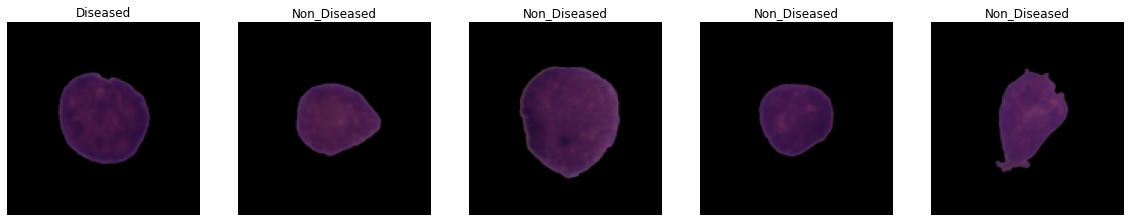

In [7]:
# Viewing Image - After Shuffle 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Diseased')
    else:
        ax[i].set_title('Non_Diseased')

In [8]:
# Assigning Images and Label to new variable 

X = Image
y = Label

In [9]:
del Image
del Label
del A
del H

In [10]:
valid_data.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [11]:
# Loading image and storing it numpy array.

X_val = []

for image_name in valid_data.new_names:
    # Loading images
    img = imread('C:/Users/lenovo/Desktop/final year project/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/' + image_name)
    # Resizing 
    img = resize(img, (128,128))
    # Appending them into list
    X_val.append(img)
 
# Converting into array
X_val = np.array(X_val)

# Storing target values as well 
y_val = valid_data.labels.values

In [12]:
# Augmentation & Applying preprocessing function of pre-trained model.

train_datagen  = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    zoom_range = 0.2,
                                    preprocessing_function=preprocess_input)
train_datagen.fit(X)

In [13]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_datagen.fit(X_val)

In [14]:
# Creating model with pre trained imagenet weights

incep_v3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(128,128,3))


In [15]:
# Model Summary 

incep_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 activation_19 (Activation)     (None, 13, 13, 64)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 activation_21 (Activation)     (None, 13, 13, 64)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 activation_24 (Activation)     (None, 13, 13, 96)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_25 (Activation)     (None, 13, 13, 64)   0           ['batch_normalization_25[0][0]'] 
                                                                                                  
 mixed2 (Concatenate)           (None, 13, 13, 288)  0           ['activation_19[0][0]',          
                                                                  'activation_21[0][0]',          
          

 conv2d_64 (Conv2D)             (None, 6, 6, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 batch_normalization_64 (BatchN  (None, 6, 6, 192)   576         ['conv2d_64[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_64 (Activation)     (None, 6, 6, 192)    0           ['batch_normalization_64[0][0]'] 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 6, 6, 192)    258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_65 (BatchN  (None, 6, 6, 192)   576         ['conv2d_65[0][0]']              
 ormalizat

                                                                                                  
 conv2d_92 (Conv2D)             (None, 2, 2, 384)    442368      ['activation_90[0][0]']          
                                                                                                  
 average_pooling2d_8 (AveragePo  (None, 2, 2, 2048)  0           ['mixed9[0][0]']                 
 oling2D)                                                                                         
                                                                                                  
 conv2d_85 (Conv2D)             (None, 2, 2, 320)    655360      ['mixed9[0][0]']                 
                                                                                                  
 batch_normalization_87 (BatchN  (None, 2, 2, 384)   1152        ['conv2d_87[0][0]']              
 ormalization)                                                                                    
          

In [16]:
# We dont want to train all layers so, we do following step because we are using same weights given in VGG16

for layers in incep_v3.layers:
    layers.trainable = False

In [17]:
# Introducing Flatten Layer

x = Flatten()(incep_v3.output)

In [18]:
# Introducing FCC & Output Layer

fcc_layer_1 = Dense(units = 1024, activation = 'relu')(x)
dropout_1   = Dropout(0.3)(fcc_layer_1)

fcc_layer_2 = Dense(units = 512, activation = 'relu')(dropout_1)
dropout_2   = Dropout(0.3)(fcc_layer_2)

final_layer = Dense(units = 1, activation = 'sigmoid')(dropout_2)

In [19]:
# Creating Final Model

model = Model(inputs = incep_v3.input, outputs = final_layer)

In [20]:
# Model summary 

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 conv2d_30 (Conv2D)             (None, 6, 6, 192)    147456      ['mixed3[0][0]']                 
                                                                                                  
 conv2d_33 (Conv2D)             (None, 6, 6, 192)    172032      ['activation_32[0][0]']          
                                                                                                  
 conv2d_38 (Conv2D)             (None, 6, 6, 192)    172032      ['activation_37[0][0]']          
                                                                                                  
 conv2d_39 (Conv2D)             (None, 6, 6, 192)    147456      ['average_pooling2d_3[0][0]']    
                                                                                                  
 batch_normalization_30 (BatchN  (None, 6, 6, 192)   576         ['conv2d_30[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 2, 2, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 2, 2, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 2, 2, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 2, 2, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 2, 2, 384)    0           ['batch_normalization_83[0][0]'] 
          

In [21]:
# Model Compile 

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [22]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                  mode = 'max',
                                  patience = 5,
                                  factor = 0.3,
                                  min_delta = 0.00001)


callback_list = [earlystopping, checkpoint, learning_rate]

In [ ]:
# Fitting Model

model_history = model.fit(train_datagen.flow(X, y, batch_size=512), 
                          validation_data = (X_val, y_val),
                          epochs = 5,
                          verbose = 1,
                          callbacks = callback_list)

Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 0.8400 - accuracy: 0.6650  
Epoch 00001: val_accuracy improved from -inf to 0.65292, saving model to .\best_weights.hdf5
21/21 [==============================] - 3457s 164s/step - loss: 0.8400 - accuracy: 0.6650 - val_loss: 3.1447 - val_accuracy: 0.6529 - lr: 0.0010
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.7473  
Epoch 00002: val_accuracy did not improve from 0.65292
21/21 [==============================] - 3292s 157s/step - loss: 0.5303 - accuracy: 0.7473 - val_loss: 3.3980 - val_accuracy: 0.6529 - lr: 0.0010
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.7702  
Epoch 00003: val_accuracy did not improve from 0.65292
21/21 [==============================] - 3151s 151s/step - loss: 0.5089 - accuracy: 0.7702 - val_loss: 3.2545 - val_accuracy: 0.6529 - lr: 0.0010
Epoch 4/5
 4/21 [====>.........................] - ETA: 36:36 - loss: 0.49